In [1]:
# imports
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# specifying directories
subject_number = 10

if subject_number >= 10:
    subject_name =  str(f"Subject_{subject_number}")
else:
    subject_name = str(f"Subject_0{subject_number}")

DATA_DIR = Path(f"./experiment_data/{subject_name}")
IN_FILE  = DATA_DIR / f"{subject_name}-data.csv"
OUT_FILE = DATA_DIR / f"optimised-{subject_name}-data.csv"


pd.set_option("display.max_columns", None)

In [3]:
# sanity check for paths
print(DATA_DIR)
print(IN_FILE)
print(OUT_FILE)

experiment_data/Subject_10
experiment_data/Subject_10/Subject_10-data.csv
experiment_data/Subject_10/optimised-Subject_10-data.csv


In [4]:
# raw data loading
raw = pd.read_csv(IN_FILE)
print(f"Raw shape : {raw.shape}")
raw.head()

Raw shape : (110, 8)


,Section,Question,Correct,Answer,Frustration,abs_time_iso,rel_time_s,Label
0,1.0,1.0,C,C,False,1970-01-11T22:32:26.430844+00:00,31.407486,QuizSubmit_1_1
1,1.0,2.0,A,A,False,1970-01-11T22:32:33.709721+00:00,38.686363,QuizSubmit_1_2
2,1.0,3.0,B,B,False,1970-01-11T22:32:38.358214+00:00,43.334855,QuizSubmit_1_3
3,1.0,4.0,B,B,False,1970-01-11T22:32:43.806386+00:00,48.783028,QuizSubmit_1_4
4,1.0,5.0,B,B,False,1970-01-11T22:32:49.028769+00:00,54.005411,QuizSubmit_1_5


In [5]:
# sorting the data chronologically

df = (
    raw
    .sort_values("rel_time_s", ascending=True)
    .reset_index(drop=True)
)

print(f"Chronologically sorted shape : {df.shape}")
df

Chronologically sorted shape : (110, 8)


,Section,Question,Correct,Answer,Frustration,abs_time_iso,rel_time_s,Label
0,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:31:55.025852+00:00,0.002494,ReadingStart
1,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:32:21.134998+00:00,26.111640,QuestionStart
2,1.0,1.0,C,C,False,1970-01-11T22:32:26.430844+00:00,31.407486,QuizSubmit_1_1
3,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:32:26.430945+00:00,31.407587,QuestionStart
4,1.0,2.0,A,A,False,1970-01-11T22:32:33.709721+00:00,38.686363,QuizSubmit_1_2
...,...,...,...,...,...,...,...,...
105,10.0,3.0,B,B,False,1970-01-11T22:48:36.965241+00:00,1001.941883,QuizSubmit_10_3
106,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:48:36.965335+00:00,1001.941977,QuestionStart
107,10.0,4.0,B,B,False,1970-01-11T22:48:40.661816+00:00,1005.638457,QuizSubmit_10_4
108,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:48:40.661942+00:00,1005.638584,QuestionStart


In [6]:
# removing rows that are entirely empty after 50 th entry

# Keep everything up to row 50 exactly as is
first_block  = df.iloc[:51].copy()

# Drop rows that are all-NaN in the remainder
second_block = df.iloc[51:].dropna(how="all").copy()

df_clean = pd.concat([first_block, second_block]).reset_index(drop=True)
print(f"After trimming empty rows: {df_clean.shape}")

After trimming empty rows: (110, 8)


In [7]:
# Add a `time_spent_s` column
# Time spent in the current label = (start of *next* event) – (start of *this* event)
df_clean["time_spent_s"] = df_clean["rel_time_s"].shift(-1) - df_clean["rel_time_s"]

# The last row has no “next event”, so its duration is undefined → keep NaN
df_clean.head(10)

,Section,Question,Correct,Answer,Frustration,abs_time_iso,rel_time_s,Label,time_spent_s
0,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:31:55.025852+00:00,0.002494,ReadingStart,26.109146
1,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:32:21.134998+00:00,26.111640,QuestionStart,5.295846
2,1.0,1.0,C,C,False,1970-01-11T22:32:26.430844+00:00,31.407486,QuizSubmit_1_1,0.000101
3,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:32:26.430945+00:00,31.407587,QuestionStart,7.278776
4,1.0,2.0,A,A,False,1970-01-11T22:32:33.709721+00:00,38.686363,QuizSubmit_1_2,0.000065
5,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:32:33.709786+00:00,38.686428,QuestionStart,4.648427
6,1.0,3.0,B,B,False,1970-01-11T22:32:38.358214+00:00,43.334855,QuizSubmit_1_3,0.000115
7,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:32:38.358328+00:00,43.334970,QuestionStart,5.448058
8,1.0,4.0,B,B,False,1970-01-11T22:32:43.806386+00:00,48.783028,QuizSubmit_1_4,0.000195
9,NaN,NaN,NaN,NaN,NaN,1970-01-11T22:32:43.806581+00:00,48.783223,QuestionStart,5.222188


In [8]:
# A new 'Section' begins every time we see 'ReadingStart'.
# enumerate them 1…N in chronological order.
section_ids = (df_clean['Label'].eq('ReadingStart').cumsum()).astype('Int64')
df_clean['Section'] = section_ids

In [9]:
# Extract <section> and <question> from labels like 'QuizSubmit_3_2'
sec_qn = df_clean['Label'].str.extract(r'QuizSubmit_(\d+)_(\d+)', expand=True)
df_clean['sec_from_submit']  = sec_qn[0].astype('Int64')
df_clean['qn_from_submit']   = sec_qn[1].astype('Int64')

# For easy access later
df_clean['is_question_start'] = df_clean['Label'].eq('QuestionStart')
df_clean.head()

,Section,Question,Correct,Answer,Frustration,abs_time_iso,rel_time_s,Label,time_spent_s,sec_from_submit,qn_from_submit,is_question_start
0,1,NaN,NaN,NaN,NaN,1970-01-11T22:31:55.025852+00:00,0.002494,ReadingStart,26.109146,<NA>,<NA>,False
1,1,NaN,NaN,NaN,NaN,1970-01-11T22:32:21.134998+00:00,26.111640,QuestionStart,5.295846,<NA>,<NA>,True
2,1,1.0,C,C,False,1970-01-11T22:32:26.430844+00:00,31.407486,QuizSubmit_1_1,0.000101,1,1,False
3,1,NaN,NaN,NaN,NaN,1970-01-11T22:32:26.430945+00:00,31.407587,QuestionStart,7.278776,<NA>,<NA>,True
4,1,2.0,A,A,False,1970-01-11T22:32:33.709721+00:00,38.686363,QuizSubmit_1_2,0.000065,1,2,False


In [10]:
# walk through each Section once, filling question numbers only
# after the first QuestionStart has appeared.

df_clean['Question'] = 'N/A'   # default
for sec_id, grp in df_clean.groupby('Section', sort=False):
    # indices in *time order* for this section
    idx = grp.index

    # Build a forward 'state machine' for current question no.
    current_q = None
    q_seen    = False          # becomes True after the first QuestionStart

    for i in idx:
        label = df_clean.at[i, 'Label']

        # If a QuizSubmit appears, parse & update current question
        m = re.match(r'QuizSubmit_\d+_(\d+)', label)
        if m:
            current_q = int(m.group(1))

        # Flip the 'question started' flag the moment we hit QuestionStart
        if df_clean.at[i, 'is_question_start']:
            q_seen = True

        # Fill only after a question has started *and* we know its number
        if q_seen and current_q is not None:
            df_clean.at[i, 'Question'] = current_q

In [11]:
# correct /answer columns
for col in ['Correct', 'Answer']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna('N/A')

In [12]:
# for frustration

df_clean['Frustration'] = df_clean['Frustration'].fillna('False')

In [13]:
# rounding up the time columns
for tcol in ['rel_time_s', 'time_spent_s']:
    if tcol in df_clean.columns:
        df_clean[tcol] = df_clean[tcol].round(2)

In [14]:
# cleaning
df_clean.drop(columns=['sec_from_submit', 'qn_from_submit', 'is_question_start'],
              inplace=True)

print("✔︎ Section / Question inference complete.")
df_clean.head(12)

✔︎ Section / Question inference complete.


,Section,Question,Correct,Answer,Frustration,abs_time_iso,rel_time_s,Label,time_spent_s
0,1,N/A,N/A,N/A,False,1970-01-11T22:31:55.025852+00:00,0.00,ReadingStart,26.11
1,1,N/A,N/A,N/A,False,1970-01-11T22:32:21.134998+00:00,26.11,QuestionStart,5.30
2,1,1,C,C,False,1970-01-11T22:32:26.430844+00:00,31.41,QuizSubmit_1_1,0.00
3,1,1,N/A,N/A,False,1970-01-11T22:32:26.430945+00:00,31.41,QuestionStart,7.28
4,1,2,A,A,False,1970-01-11T22:32:33.709721+00:00,38.69,QuizSubmit_1_2,0.00
5,1,2,N/A,N/A,False,1970-01-11T22:32:33.709786+00:00,38.69,QuestionStart,4.65
6,1,3,B,B,False,1970-01-11T22:32:38.358214+00:00,43.33,QuizSubmit_1_3,0.00
7,1,3,N/A,N/A,False,1970-01-11T22:32:38.358328+00:00,43.33,QuestionStart,5.45
8,1,4,B,B,False,1970-01-11T22:32:43.806386+00:00,48.78,QuizSubmit_1_4,0.00
9,1,4,N/A,N/A,False,1970-01-11T22:32:43.806581+00:00,48.78,QuestionStart,5.22


In [15]:
# persisting the optimised csv
df_clean.to_csv(OUT_FILE, index=False)
print(f"✅ Optimised file written to: {OUT_FILE.resolve()}")

✅ Optimised file written to: /Users/rahul/PycharmProjects/Thesis-EEG/Data Processing(Acquired)/experiment_data/Subject_10/optimised-Subject_10-data.csv


In [16]:
# sanity check

print("Unique labels ➜", df_clean["Label"].unique()[:10], "...")
print("\nEvent duration stats (sec):")
display(df_clean["time_spent_s"].describe())

Unique labels ➜ ['ReadingStart' 'QuestionStart' 'QuizSubmit_1_1' 'QuizSubmit_1_2'
 'QuizSubmit_1_3' 'QuizSubmit_1_4' 'QuizSubmit_1_5' 'QuizSubmit_2_1'
 'QuizSubmit_2_2' 'QuizSubmit_2_3'] ...

Event duration stats (sec):


count    109.000000
mean       9.283394
std       16.966473
min        0.000000
25%        0.000000
50%        4.490000
75%        9.000000
max      101.520000
Name: time_spent_s, dtype: float64

# visualizations and data insights

In [17]:
opt_file_path = DATA_DIR / f"optimised-{subject_name}-data.csv"

df = pd.read_csv(opt_file_path)

In [18]:
# a unique ID per question (Section-Question, e.g. "3-2")
df["QuestionID"] = (
    df["Section"].astype("Int64").astype(str)
    + "-" +
    df["Question"].astype(str)
)

In [19]:
# Making sure I have a usable duration column
if "time_spent_s" not in df.columns:
    df = df.sort_values("rel_time_s").reset_index(drop=True)
    df["time_spent_s"] = df["rel_time_s"].shift(-1) - df["rel_time_s"]


# Colour palette (adjust to taste)
COLORS = {
    "ReadingStart" : "#4daf4a",
    "QuestionStart": "#377eb8",
    "QuizSubmit"   : "#e41a1c",
}

### experiment timeline visualization

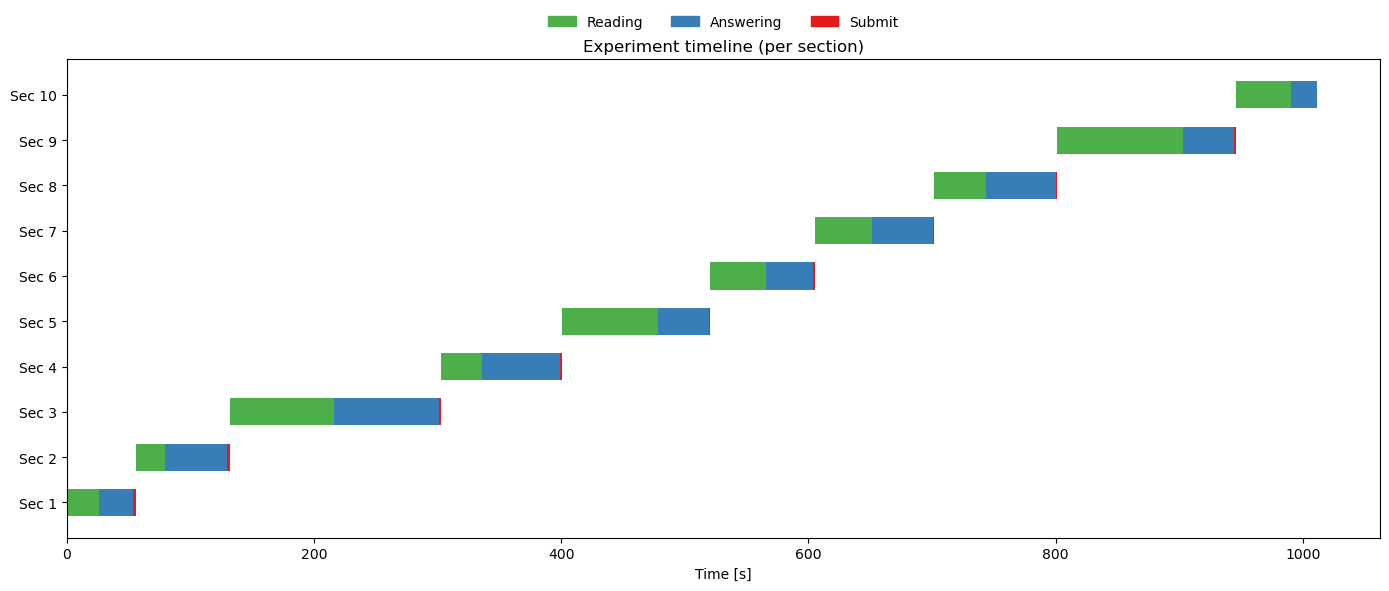

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot every event as a bar on its section-row
for _, row in df.sort_values("rel_time_s").iterrows():
    sec       = int(row["Section"])
    y         = sec - 1                      # zero-based y-coord
    start     = row["rel_time_s"]
    duration  = row["time_spent_s"]
    if pd.isna(duration) or duration <= 0:
        continue

    label = (
        "QuizSubmit" if str(row["Label"]).startswith("QuizSubmit")
        else row["Label"]
    )
    ax.barh(
        y=y,
        width=duration,
        left=start,
        height=0.6,
        color=COLORS.get(label, "#999999"),
    )

# Formatting
ax.set_yticks(range(len(df["Section"].dropna().unique())))
ax.set_yticklabels([f"Sec {n}" for n in df["Section"].dropna().unique()])
ax.set_xlabel("Time [s]")
ax.set_title("Experiment timeline (per section)")

legend_handles = [
    mpatches.Patch(color=COLORS["ReadingStart"],  label="Reading"),
    mpatches.Patch(color=COLORS["QuestionStart"], label="Answering"),
    mpatches.Patch(color=COLORS["QuizSubmit"],    label="Submit"),
]
ax.legend(handles=legend_handles, loc="upper center",
          bbox_to_anchor=(0.5, 1.12), ncol=3, frameon=False)
plt.tight_layout()
plt.show()

### Per-section time budget (reading vs. answering)

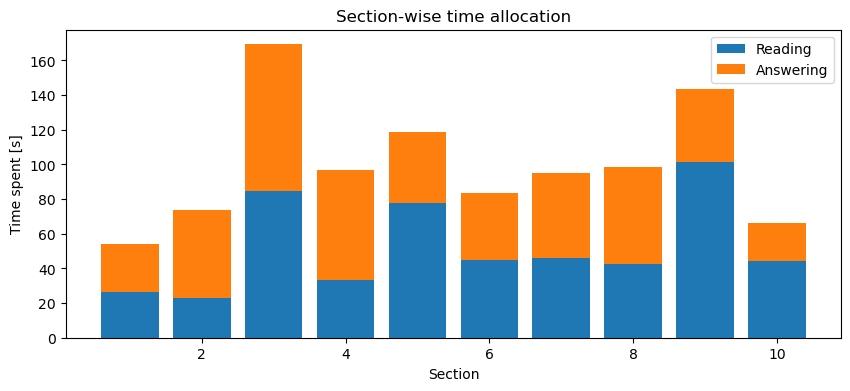

In [21]:
reading  = df[df["Label"] == "ReadingStart"].groupby("Section")["time_spent_s"].sum()
answer   = df[df["Label"] == "QuestionStart"].groupby("Section")["time_spent_s"].sum()

sections = reading.index.astype(int)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(sections, reading, label="Reading")
ax.bar(sections, answer,  bottom=reading, label="Answering")

ax.set_xlabel("Section")
ax.set_ylabel("Time spent [s]")
ax.set_title("Section-wise time allocation")
ax.legend()
plt.show()

### distribution of durations by task type

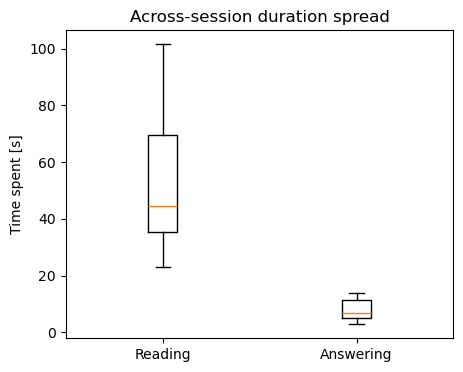

In [22]:
fig, ax = plt.subplots(figsize=(5, 4))

box_data = [
    df[df["Label"] == "ReadingStart"]["time_spent_s"].dropna(),
    df[df["Label"] == "QuestionStart"]["time_spent_s"].dropna()
]

ax.boxplot(box_data, tick_labels=["Reading", "Answering"], showfliers=False)
ax.set_ylabel("Time spent [s]")
ax.set_title("Across-session duration spread")
plt.show()

### Answering-time vs. correctness (proxy for frustration)

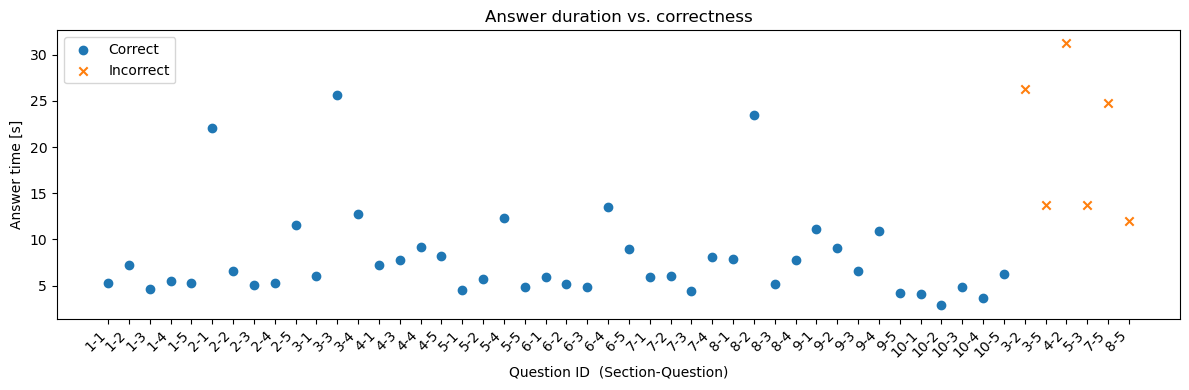

In [23]:
# ── 1. Load & prep
df = pd.read_csv(OUT_FILE).sort_values("rel_time_s").reset_index(drop=True)

# handy numeric versions
df["Section_num"]  = pd.to_numeric(df["Section"],  errors="coerce")
df["Question_num"] = pd.to_numeric(df["Question"], errors="coerce")

# ── 2. Build one record per QuizSubmit row ────────────────────────────────
records = []
for _, submit in df[df["Label"].str.startswith("QuizSubmit")].iterrows():

    # extract section & question from the label text
    m = re.match(r"QuizSubmit_(\d+)_(\d+)", submit["Label"])
    if not m:
        continue                               # shouldn’t happen, but be safe
    sec, qn = map(int, m.groups())
    t_submit = submit["rel_time_s"]

    # last QuestionStart in *this* section that happened *before* the submit
    mask_q = (
        (df["Label"] == "QuestionStart") &
        (df["Section_num"] == sec)       &
        (df["rel_time_s"]  <  t_submit)
    )
    if not mask_q.any():
        continue                           # skip if start not found (rare)

    qstart = df.loc[mask_q].iloc[-1]       # the closest one going backwards
    duration = t_submit - qstart["rel_time_s"]

    # correctness = did the participant’s answer match the key?
    is_correct = str(submit["Answer"]) == str(submit["Correct"])

    records.append({
        "QuestionID": f"{sec}-{qn}",
        "duration_s": round(duration, 2),
        "is_correct": is_correct,
    })

qd = pd.DataFrame(records)

if qd.empty:
    raise RuntimeError("No question/submit pairs found — check log format!")

# ── 3. Scatter plot ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(
    qd[qd["is_correct"]]["QuestionID"],
    qd[qd["is_correct"]]["duration_s"],
    label="Correct", marker="o"
)
ax.scatter(
    qd[~qd["is_correct"]]["QuestionID"],
    qd[~qd["is_correct"]]["duration_s"],
    label="Incorrect", marker="x"
)

ax.set_xlabel("Question ID  (Section-Question)")
ax.set_ylabel("Answer time [s]")
ax.set_title("Answer duration vs. correctness")
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()